# Getting estimates out of DisMod-MR

The goal of this document is to demonstrate how to export age-specific prevalence estimates from DisMod-MR in a comma-separated value (CSV) format, for use in subsequent analysis.

It uses data from the replication dataset for regional estimates of HCV prevalence, as published in Mohd Hanafiah K, Groeger J, Flaxman AD, Wiersma ST. Global epidemiology of hepatitis C virus infection: New estimates of age-specific antibody to HCV seroprevalence. Hepatology. 2013 Apr;57(4):1333-42. doi: 10.1002/hep.26141. Epub 2013 Feb 4.  http://www.ncbi.nlm.nih.gov/pubmed/23172780

The dataset is available from: http://ghdx.healthdata.org/sites/default/files/record-attached-files/IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP

    wget http://ghdx.healthdata.org/sites/default/files/record-attached-files/IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP
    unzip IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP

In [1]:
!wget http://ghdx.healthdata.org/sites/default/files/record-attached-files/IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP
!unzip IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP

--2019-07-23 13:51:38--  http://ghdx.healthdata.org/sites/default/files/record-attached-files/IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP
Resolving ghdx.healthdata.org (ghdx.healthdata.org)... 2606:4700:10::6814:316, 2606:4700:10::6814:216, 104.20.3.22, ...
Connecting to ghdx.healthdata.org (ghdx.healthdata.org)|2606:4700:10::6814:316|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74164 (72K) [application/zip]
Saving to: 'IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP'

100%[======================================>] 74,164      --.-K/s   in 0s      

2019-07-23 13:51:38 (622 MB/s) - 'IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP' saved [74164/74164]

Archive:  IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP
  inflating: hcv_replication/2013_04_12_hcv_replication_code.ipynb  
  inflating: hcv_replication/2013_04_12_hcv_replication_code.py  
  inflating: hcv_replication/hierarchy.json  
  inflating: hcv_replication/input_data.csv  
  inflating: hcv_replica

In [2]:
# This Python code will export predictions 
# for the following region/sex/year:
predict_region = 'USA'
predict_sex = 'male'
predict_year = 2005

In [3]:
# import dismod code
import dismod_mr

Load the model, and keep only data for the prediction region/sex/year

In [4]:
model_path = 'hcv_replication/'
dm = dismod_mr.data.load(model_path)

if predict_year == 2005:
    dm.keep(areas=[predict_region], sexes=['total', predict_sex], start_year=1997)
elif predict_year == 1990:
    dm.keep(areas=[predict_region], sexes=['total', predict_sex], end_year=1997)
else:
    raise(Error, 'predict_year must equal 1990 or 2005')

kept 20 rows of data


In [5]:
# Fit model using the data subset (faster, but no borrowing strength)
dm.vars += dismod_mr.model.process.age_specific_rate(dm, 'p', predict_region, predict_sex, predict_year)
%time dismod_mr.fit.asr(dm, 'p', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'mu': 0.0, 'dist': 'Normal', 'sigma': 0.0001}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.36
sampling from posterior

CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 22s


(<pymc.NormalApproximation.MAP at 0x7f6c0e29aba8>,
 <pymc.MCMC.MCMC at 0x7f6c15c746a0>)

In [6]:
# Make posterior predictions
pred = dismod_mr.model.covariates.predict_for(
            dm, dm.parameters['p'],
            predict_region, predict_sex, predict_year,
            predict_region, predict_sex, predict_year, True, dm.vars['p'], 0, 1)

The easiest way to get these predictions into a csv file is to use the Python Pandas package:

In [7]:
import pandas as pd

In [8]:
# This generates a csv with 1000 rows,
# one for each draw from the posterior distribution

# Each column corresponds to a one-year age group,
# e.g. column 10 is prevalence at age 10

pd.DataFrame(pred).to_csv(
    model_path + '%s-%s-%s.csv'%(predict_region, predict_sex, predict_year))

In [9]:
!ls -hal hcv_replication/$predict_region-*.csv

-rw-r--r-- 1 abie Domain Users 2.1M Jul 23 13:53 hcv_replication/USA-male-2005.csv


To aggregate this into pre-specified age categories, you need to specify the age weights and groups:

In [10]:
weights = [1, 8, 8, 9, 9, 10, 10, 10, 10, 10,
           10, 10, 10, 10, 9, 9, 9, 9, 9, 9,
           9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
           9, 9, 8, 8, 8, 8, 8, 8, 8, 8,
           8, 7, 7, 7, 7, 7, 7, 7, 7, 7,
           6, 6, 6, 6, 6, 6, 5, 5, 5, 5,
           5, 5, 4, 4, 4, 4, 4, 4, 4, 3,
           3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

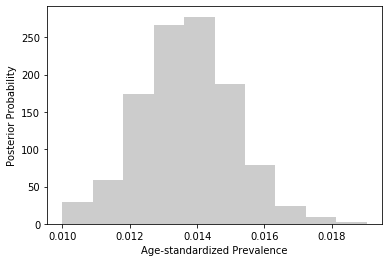

In [11]:
# 1000 samples from the posterior distribution for age-standardized prevalence
import numpy as np, matplotlib.pyplot as plt

age_std = np.dot(pred, weights) / np.sum(weights)
plt.hist(age_std, color='#cccccc', density=True)
plt.xlabel('Age-standardized Prevalence')
plt.ylabel('Posterior Probability');

You can extract an age-standardized point and interval estimate from the 1000 draws from the posterior distribution stored in age_std as follows:  (to do this for crude prevalence, use the population weights to average, instead of standard weights.)

In [12]:
import pymc as mc

print('age_std prev mean:', age_std.mean())
print('age_std prev 95% UI:', mc.utils.hpd(age_std, .05))

age_std prev mean: 0.013684724543190618
age_std prev 95% UI: [0.01056258 0.01612552]


For groups, just do the same thing group by group:

In [13]:
group_cutpoints = [0, 1,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 100]

In [14]:
results = []
for a0, a1 in zip(group_cutpoints[:-1], group_cutpoints[1:]):
    age_grp = np.dot(pred[:, a0:a1], weights[a0:a1]) / np.sum(weights[a0:a1])
    results.append(dict(a0=a0,a1=a1,mu=age_grp.mean(),std=age_grp.std()))
    
results = pd.DataFrame(results)
print(np.round(results.head(), 2))

   a0  a1   mu  std
0   0   1  0.0  0.0
1   1   5  0.0  0.0
2   5  10  0.0  0.0
3  10  15  0.0  0.0
4  15  20  0.0  0.0


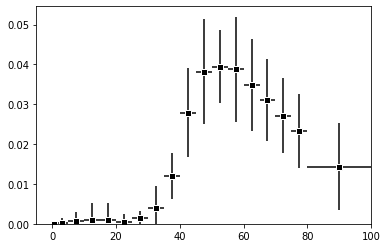

In [15]:
plt.errorbar(.5*(results.a0+results.a1), results.mu,
             xerr=.5*(results.a1-results.a0),
             yerr=1.96*results['std'],
             fmt='ks', capsize=0, mec='w')
plt.axis(ymin=0, xmax=100);

In [18]:
!rm IHME_GBD_HEP_C_RESEARCH_ARCHIVE_Y2013M04D12.ZIP
!rm -r hcv_replication/

In [17]:
!date

Tue Jul 23 13:53:06 PDT 2019
